# **Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small
from timm.models.vision_transformer import VisionTransformer
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from PIL import Image

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Dataset Overview

In [2]:
base_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/"

paths = {
    "lung_aca": os.path.join(base_dir, "lung_image_sets/lung_aca"),
    "lung_scc": os.path.join(base_dir, "lung_image_sets/lung_scc"),
    "lung_n": os.path.join(base_dir, "lung_image_sets/lung_n")
}

image_paths = []
labels = []

for label, path in paths.items():
    for filename in os.listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  
            image_paths.append(os.path.join(path, filename))
            labels.append(label)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [3]:
df['label'].value_counts()

label
lung_aca    5000
lung_scc    5000
lung_n      5000
Name: count, dtype: int64

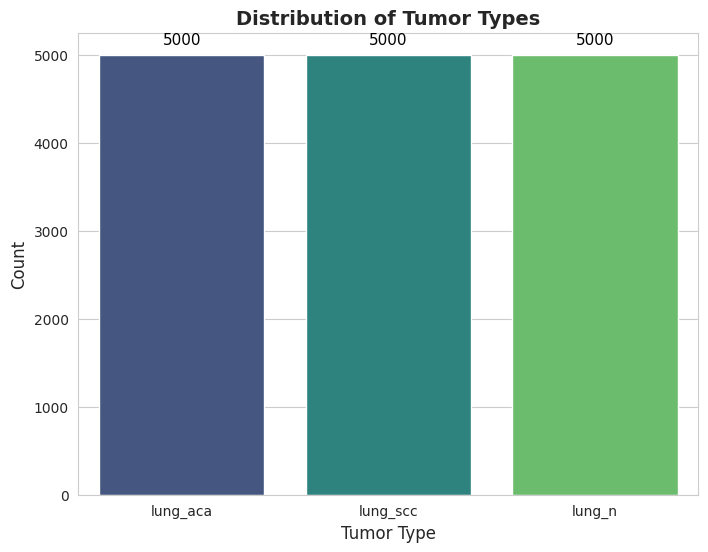

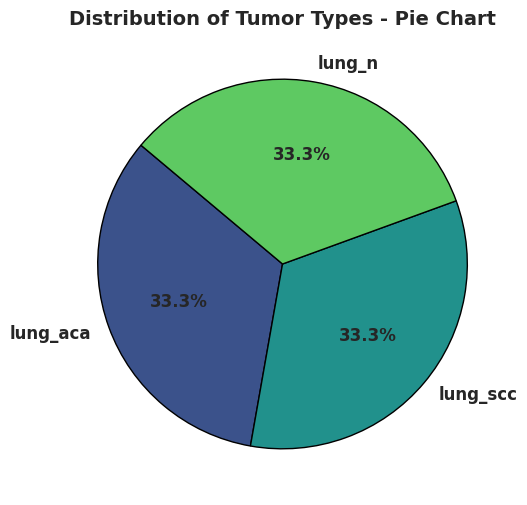

In [4]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

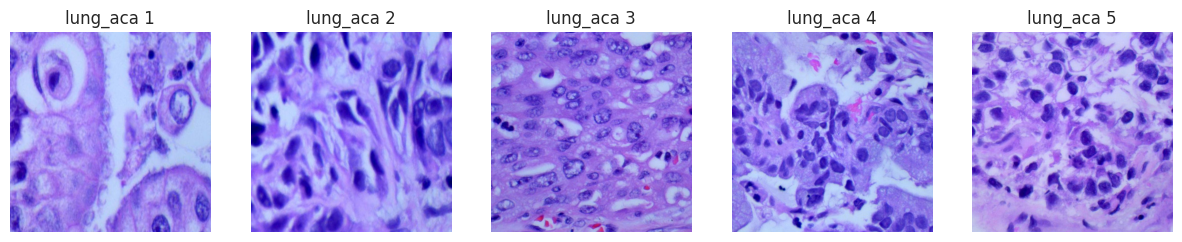

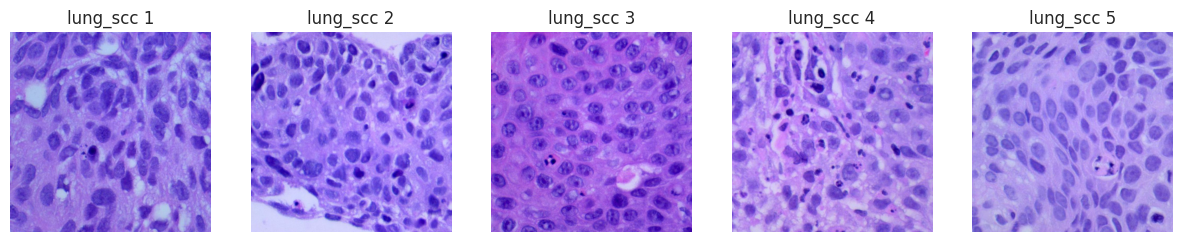

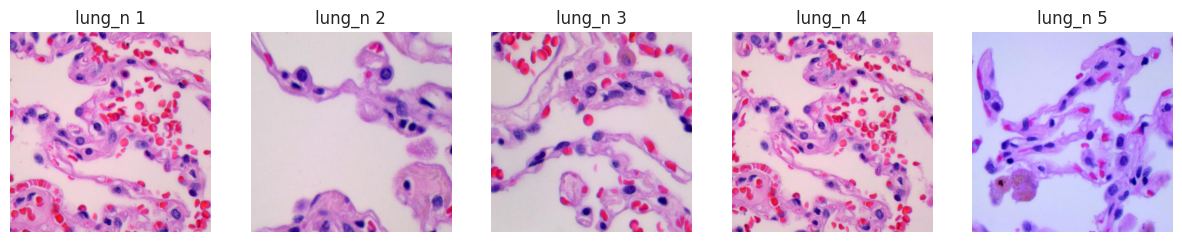

In [5]:
# Visualize one image per class
def display_images(category, path, num_images=5):
    image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files = image_files[:num_images]  
    
    plt.figure(figsize=(15, 3))
    for i, image_file in enumerate(image_files, 1):
        img_path = os.path.join(path, image_file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f"{category} {i}")
        plt.axis('off')
    plt.show()

for category, path in paths.items():
    display_images(category, path)


# Data Preprocessing

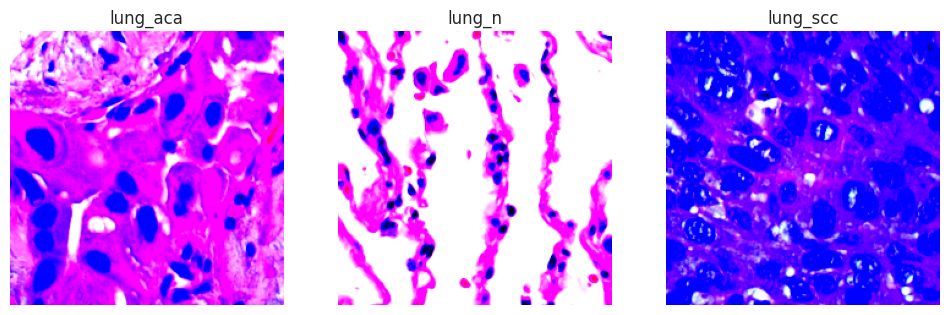

In [6]:
ROOT = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/"
data = datasets.ImageFolder(os.path.join(ROOT, "lung_image_sets"))

# Access class names from the dataset
class_names = data.classes  # This gives the class names

# Loop through the dataset and count the images per class
for _, label in data.samples:
    class_name = class_names[label]
    
# Define transforms for training and validation
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

#Load Dataset
lung_ds  = datasets.ImageFolder(os.path.join(ROOT, "lung_image_sets"),  transform=tfm)

# Visualize one image per class
def visualize_sample_images(dataset, num_classes=3):
    fig, axes = plt.subplots(1, num_classes, figsize=(12, 4))
    
    for i, class_name in enumerate(dataset.classes):
        # Get a sample image from the current class
        class_idx = dataset.class_to_idx[class_name]
        
        # Loop through the dataset to find an image of the current class
        for img, label in dataset:
            if label == class_idx:
                img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC format for displaying
                axes[i].imshow(img)
                axes[i].set_title(class_name)
                axes[i].axis('off')
                break  # Display only one image per class

    plt.show()

# Call the function to visualize images
visualize_sample_images(lung_ds, num_classes=3)

# Split Train, Valid and Test Data

In [7]:
# Split dataset (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(lung_ds))
val_size = int(0.1 * len(lung_ds))
test_size = len(lung_ds) - train_size - val_size  # remaining 10% for test
train_ds, val_ds, test_ds = random_split(lung_ds, [train_size, val_size, test_size])

# DataLoader for training, validation, and test
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Hybrid MobileNetV3 + ViT

In [8]:
# Define the hybrid MobileNetV3 + ViT model
class MBv3toViT(nn.Module):
    def __init__(self, num_classes, vit_dim=768, vit_depth=8, vit_heads=12, drop=0.1):
        super().__init__()
        # 1) MobileNetV3 backbone (feature extractor)
        mb = mobilenet_v3_small(pretrained=True)
        self.backbone = mb.features  # outputs ~[B, 576, 7, 7] for 224×224

        # Channel dimension coming out of MBv3-small:
        self.cnn_out_ch = 576  # (check via a dummy forward if you change MBv3 config)

        # 2) Project CNN channels -> ViT embed dim
        self.proj = nn.Conv2d(self.cnn_out_ch, vit_dim, kernel_size=1)

        # 3) ViT encoder (no patch embed, we already have tokens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, vit_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + 49, vit_dim))  # 49 for 7×7
        self.pos_drop = nn.Dropout(drop)

        # a compact ViT encoder from timm (set patch_size=1; we won’t use its patch embed)
        self.vit = VisionTransformer(
            img_size=14, patch_size=1, in_chans=vit_dim, num_classes=num_classes,
            embed_dim=vit_dim, depth=vit_depth, num_heads=vit_heads, mlp_ratio=4.0,
            qkv_bias=True, drop_rate=drop, attn_drop_rate=drop, drop_path_rate=0.0
        )
        # We’ll bypass ViT’s own patch embedding and class token handling.

        # Replace its head only; we’ll drive the encoder blocks directly
        self.head = nn.Linear(vit_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        # CNN features: [B, 576, 7, 7]
        f = self.backbone(x)
        # Project to ViT dim: [B, D, 7, 7]
        f = self.proj(f)
        # Flatten to tokens: [B, 49, D]
        f = f.flatten(2).transpose(1, 2)

        # Add CLS + positions
        cls = self.cls_token.expand(B, -1, -1)       # [B, 1, D]
        tokens = torch.cat([cls, f], dim=1)          # [B, 50, D]
        tokens = tokens + self.pos_embed
        tokens = self.pos_drop(tokens)

        # Feed through ViT blocks (bypass patch embed; use blocks + norm)
        for blk in self.vit.blocks:
            tokens = blk(tokens)
        tokens = self.vit.norm(tokens)
        cls_out = tokens[:, 0]                       # [B, D]

        return self.head(cls_out)

# Model Initialization

In [9]:
# Initialize model
num_classes = len(lung_ds.classes)  # LC25000 has 5 classes
model = MBv3toViT(num_classes=num_classes)
# Check for GPU and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device (GPU or CPU)
model = MBv3toViT(num_classes=num_classes).to(device)

# Loss function and optimizer (no change needed for this part)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 147MB/s]


# Model Training

In [10]:
from tqdm import tqdm

# Modify the training and evaluation loops to show progress bars
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Use tqdm to show a progress bar for each batch in the epoch
    progress_bar = tqdm(dataloader, desc="Training", unit="batch", leave=False)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update the progress bar description
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct / total)
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    # Use tqdm to show a progress bar for each batch in the evaluation
    progress_bar = tqdm(dataloader, desc="Evaluating", unit="batch", leave=False)
    
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update the progress bar description
            progress_bar.set_postfix(loss=loss.item(), accuracy=correct / total)
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop (with tqdm for batch-level progress)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store the metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.1482, Train Accuracy: 0.9445
Val Loss: 0.0311, Val Accuracy: 0.9880


Epoch 2/10
Train Loss: 0.0408, Train Accuracy: 0.9858
Val Loss: 0.0342, Val Accuracy: 0.9880


Epoch 3/10
Train Loss: 0.0201, Train Accuracy: 0.9934
Val Loss: 0.0099, Val Accuracy: 0.9967


Epoch 4/10
Train Loss: 0.0123, Train Accuracy: 0.9964
Val Loss: 0.0055, Val Accuracy: 0.9987


Epoch 5/10
Train Loss: 0.0066, Train Accuracy: 0.9978
Val Loss: 0.0109, Val Accuracy: 0.9987


Epoch 6/10
Train Loss: 0.0199, Train Accuracy: 0.9931
Val Loss: 0.0032, Val Accuracy: 0.9993


Epoch 7/10
Train Loss: 0.0060, Train Accuracy: 0.9981
Val Loss: 0.0011, Val Accuracy: 0.9993


Epoch 8/10
Train Loss: 0.0033, Train Accuracy: 0.9988
Val Loss: 0.0119, Val Accuracy: 0.9980


Epoch 9/10
Train Loss: 0.0054, Train Accuracy: 0.9992
Val Loss: 0.0250, Val Accuracy: 0.9927


Epoch 10/10
Train Loss: 0.0137, Train Accuracy: 0.9963
Val Loss: 0.0161, Val Accuracy: 0.9960


# Model Testing on Test Data

In [11]:
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            # Move data to the correct device (GPU or CPU)
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Test the model after training
test_loss, test_acc = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0168, Test Accuracy: 0.9980


# Confusion Matrix

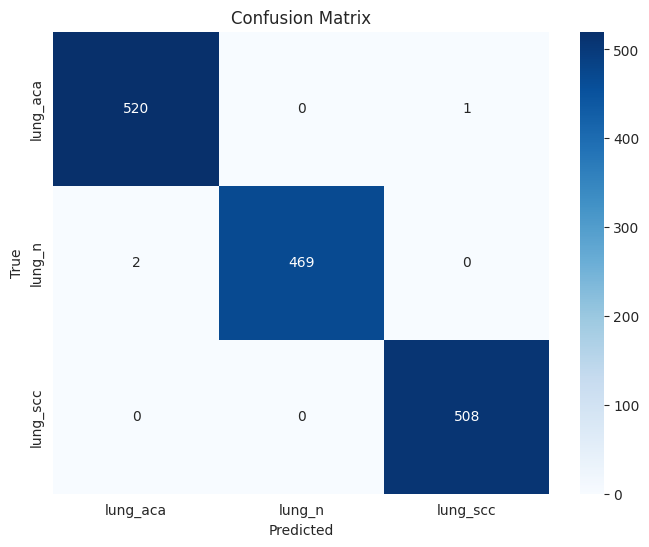

In [12]:

# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, device, dataset):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function after testing
plot_confusion_matrix(model, test_loader, device, lung_ds)  # Pass the original full_ds dataset


# Training and Validation Visualization

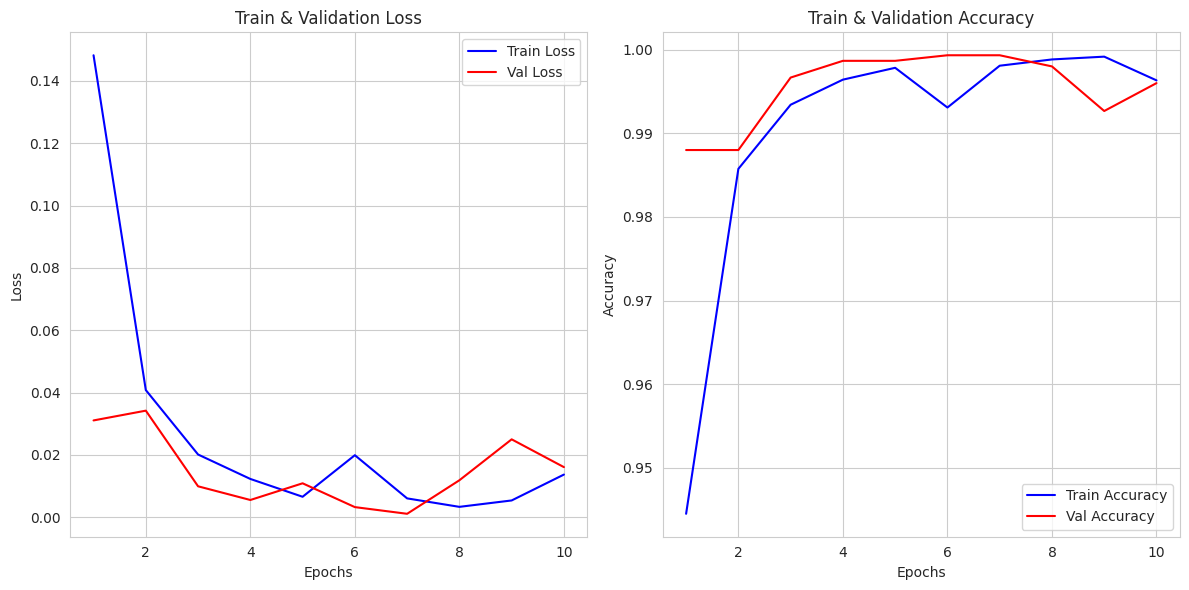

In [13]:
# Plotting the metrics
epochs = range(1, num_epochs+1)

# Train and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
plt.legend()

# Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ✅ Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("Classification Report:\n")
    print(report)

    return report


In [15]:

report = evaluate_model(model, test_loader, device, class_names)



Classification Report:

              precision    recall  f1-score   support

    lung_aca     0.9962    0.9981    0.9971       521
      lung_n     1.0000    0.9958    0.9979       471
    lung_scc     0.9980    1.0000    0.9990       508

    accuracy                         0.9980      1500
   macro avg     0.9981    0.9979    0.9980      1500
weighted avg     0.9980    0.9980    0.9980      1500



In [16]:
import torch

# Assuming 'model' is your trained model
torch.save(model.state_dict(), 'model.pth')  # Save the model weights
